In [1]:
#coding: utf-8

import warnings
warnings.simplefilter("ignore")

import os
import sys 
import wave
import time
import librosa
import numpy as np
import seaborn as sns
from utils import *
import matplotlib.pyplot as plt
from StringIO import StringIO

%pylab inline

# sudo pip install librosa
# ubuntu: sudo apt-get install libav-tools
# OSX   : brew install libav OMP_NUM_THREADS=2

Populating the interactive namespace from numpy and matplotlib


# Get the Data

Датасет для контеста помещен вот здесь: https://yadi.sk/d/3jmeVCfSwTKgm (внимание! файл весит 3,5 Гб)


Он распаковывается в папку "musicdata". Все пути в этом ноутбуке будут относительно этой папки: "./musicdata/\*". 

Вы можете изменить базовый путь, как вам удобно.

In [2]:
BP = "./musicdata/"

# Just a Sound

Для начала попробуем поработать со звуком - послушайте любой трек, постройте график сырых данных и спектрограмму.

In [3]:
import IPython
from IPython import display

def Audio(url):
    return display.HTML("<center><audio controls><source src='{}' type=\"audio/wav\"></audio>".format(url))

In [4]:
# sound_file = os.path.join(BP, "audiosamples", "short_206377.wav")
sound_file = "./short_206377.wav"
y, sr = librosa.load(sound_file)

Audio(url=sound_file)

# Sound as 1D-Signal

22050
(220500,)


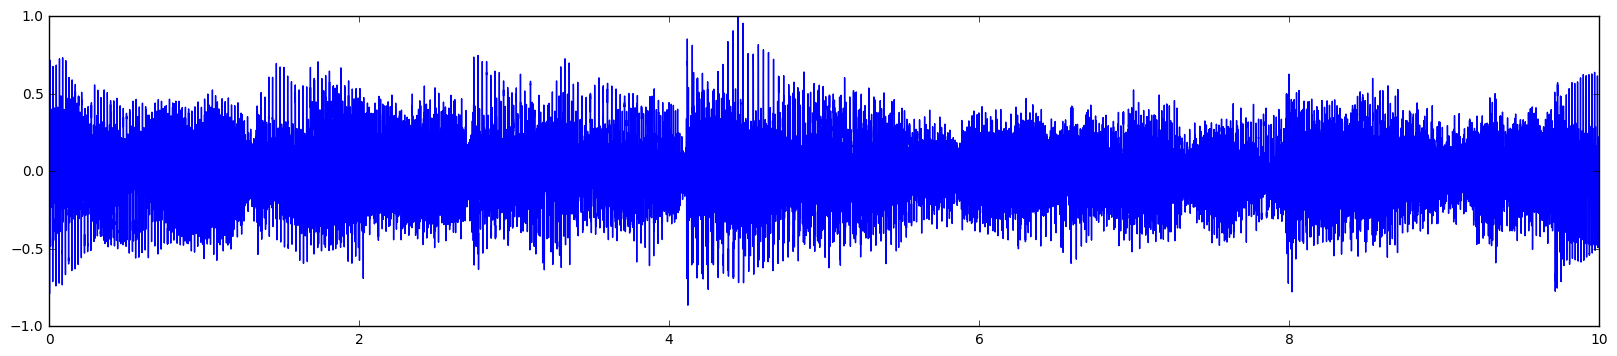

In [5]:
plt.figure(figsize=(20,4))
# 
# Используйте pylab.plot для построения графика, нарисуйте y, sr
#
print len(range(sr))
print y.shape

pylab.plot(np.linspace(0, 10.1, y.shape[0]), y)

pylab.xlim([0, 10])
pylab.show()

# Sound as 2D-Signal

Нашу цель слелать из предыдущего графика картинку - для этого нам нужно оценить частоты в каждый момент времени. Благо за нас это умеет делать librosa, у которой внутри STFFT. Используйте librosa.feature.melspectrogram -- для получения спектрограммы, и librosa.logamplitude для выравнивания диапазонов частот. 

help: https://gist.github.com/mailletf/3484932dd29d62b36092

In [6]:
S = librosa.feature.melspectrogram(y)
log_S = librosa.logamplitude(S)

Нарисуйте спектрограмму, получилась красивая картинка?

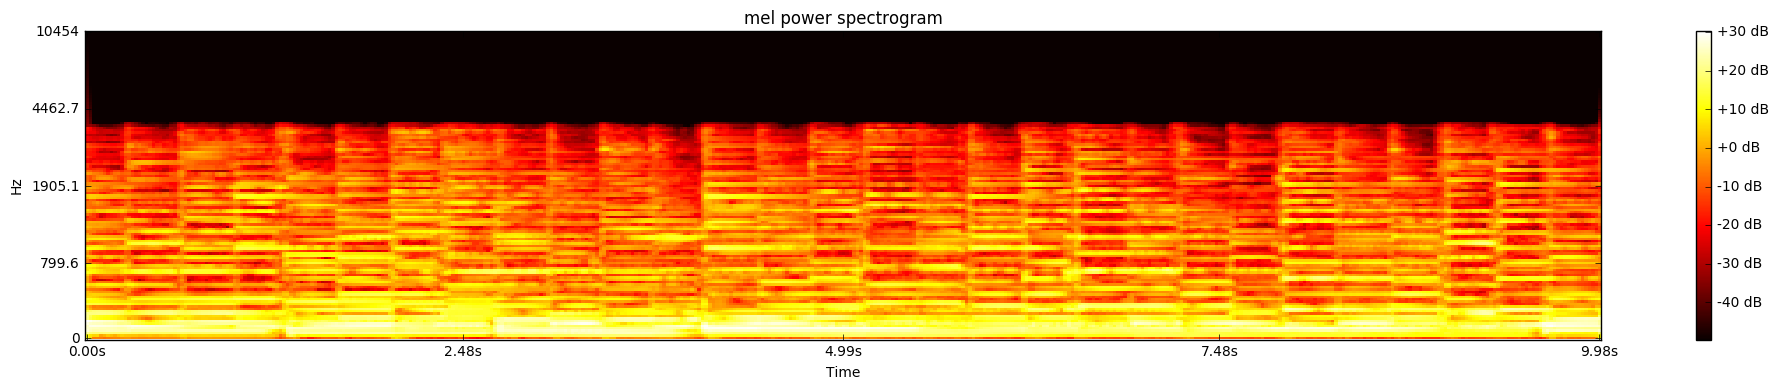

In [7]:
plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='hot')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

# Prepare the Data

В этой секции мы создадим датасет, прочитав все данные.

In [8]:
import numpy as np
X = np.load(os.path.join(BP, "spectrograms", "spectrograms1.pcl"))

In [9]:
for i in xrange(2, 7):
    X = np.concatenate((X, np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(i)))))

Здесь вы должны получить train genres. Они идут подряд в соответствии с последовательностью треков в файлах с данными. Для содержимого первых шести файлов у вас есть жанры, а для последнего файла, вам их нужно предсказать.

In [10]:
from sklearn.preprocessing import LabelEncoder

print X.shape
train_genres = []
with open(os.path.join(BP, "train_genres.txt"), "rt") as f_in:
    train_genres = f_in.readlines()
    
encoder = LabelEncoder()
y = encoder.fit_transform(train_genres)
print len(y)

(12000, 128, 431)
12000


In [11]:
num_classes = len(set(train_genres))
print num_classes

67


# Nearest Neighbors genre classification

Let's try to solve similarity task by the nearest neighbour approach.

<img src="./img/nn.png" width="300">

Перемешаем датасет - используйте `np.random.permutation` и индексацию `a[np.random.permutation]`.

In [12]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm], np.array(y)[perm]
Xreshape = X

Разобьем датасет на трейн и валидацию 80/20%.

In [13]:
train_split = 10000
X_train, X_valid = Xreshape[:train_split], Xreshape[train_split:]
y_train, y_valid = y[:train_split], y[train_split:]

Попробуем поклассифицировать жанры методом ближайших соседей.

In [14]:
%%time

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf = clf.fit(X_train.reshape((X_train.shape[0], -1)), y_train)
y_val_pred = clf.predict(X_valid.reshape((X_valid.shape[0], -1)))

print accuracy_score(y_valid, y_val_pred)

0.1
CPU times: user 23min 29s, sys: 0 ns, total: 23min 29s
Wall time: 23min 31s


# Fully-Connected Neural Nets

Использовать нейросети - это хорошая идея, давайте начнем с полносвязных сетей.

In [15]:
import theano
import lasagne
import theano.tensor as T

from utils import train_net

Перемешаем и разобьем датасет.

In [16]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:train_split], Xreshape[train_split:]
y_train, y_valid = y[:train_split], y[train_split:]

In [17]:
input_X, target_y = T.tensor4("X", dtype='float32'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, 1, X.shape[1], X.shape[2]), input_var=input_X) 

nn = lasagne.layers.DenseLayer(nn, num_units=512)
nn = lasagne.layers.DenseLayer(nn, num_units=256)
nn = lasagne.layers.DenseLayer(nn, num_units=num_classes, nonlinearity=lasagne.nonlinearities.softmax)
#
# Используйте 2-3 больших полносвязных слоя, обучилась ли сеть? если нет то почему?
#

y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [18]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [19]:
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=10, batch_size=50)

Epoch   1 of  10 train_loss = 1002.03 val_loss = 4.12 train_acc = 13.06 val_acc = 9.70
Epoch   2 of  10 train_loss = 3.33 val_loss = 2.90 train_acc = 34.60 val_acc = 34.40
Epoch   3 of  10 train_loss = 2.76 val_loss = 2.74 train_acc = 35.17 val_acc = 34.35
Epoch   4 of  10 train_loss = 2.66 val_loss = 2.70 train_acc = 35.17 val_acc = 34.35
Epoch   5 of  10 train_loss = 2.64 val_loss = 2.69 train_acc = 35.17 val_acc = 34.35
Epoch   6 of  10 train_loss = 2.64 val_loss = 2.69 train_acc = 35.17 val_acc = 34.35
Epoch   7 of  10 train_loss = 2.64 val_loss = 2.69 train_acc = 35.17 val_acc = 34.35
Epoch   8 of  10 train_loss = 2.64 val_loss = 2.69 train_acc = 35.17 val_acc = 34.35
Epoch   9 of  10 train_loss = 2.64 val_loss = 2.69 train_acc = 35.17 val_acc = 34.35
Epoch  10 of  10 train_loss = 2.64 val_loss = 2.69 train_acc = 35.17 val_acc = 34.35
CPU times: user 44min 25s, sys: 42min 28s, total: 1h 26min 54s
Wall time: 14min 9s


# Convolution Neural Nets

Да, вероятно, полносвязные сети не зажгли и kNN не обогнали. Давайте попробуем сверточные, хороший вариант делать одномерные свертки (сразу по всем частотам). Хотя двумерные тоже могут работать. 

Архитектуру можно подсмотреть [тут](http://benanne.github.io/2014/08/05/spotify-cnns.html).

In [20]:
import theano
import lasagne
import theano.tensor as T

from utils import train_net

In [21]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]
Xreshape = X

X_train, X_valid = Xreshape[:10000], Xreshape[10000:]
y_train, y_valid = y[:10000], y[10000:]

In [22]:
input_X, target_y = T.tensor3("X", dtype='float64'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X) 

nn = lasagne.layers.Conv1DLayer(nn, num_filters=32, filter_size=4)
print nn.output_shape
nn = lasagne.layers.MaxPool1DLayer(nn, pool_size=4)
print nn.output_shape
nn = lasagne.layers.Conv1DLayer(nn, num_filters=32, filter_size=4)
print nn.output_shape
nn = lasagne.layers.MaxPool1DLayer(nn, pool_size=4)
print nn.output_shape
nn = lasagne.layers.Conv1DLayer(nn, num_filters=32, filter_size=4)
print nn.output_shape
nn = lasagne.layers.MaxPool1DLayer(nn, pool_size=2)
print nn.output_shape
nn = lasagne.layers.Conv1DLayer(nn, num_filters=32, filter_size=4)
print nn.output_shape
nn = lasagne.layers.GlobalPoolLayer(nn)
print nn.output_shape
nn = lasagne.layers.DenseLayer(nn, 128)
print nn.output_shape
nn = lasagne.layers.DropoutLayer(nn)
print nn.output_shape
nn = lasagne.layers.DenseLayer(nn, 128)
print nn.output_shape

nn = lasagne.layers.DenseLayer(nn, num_classes, nonlinearity=lasagne.nonlinearities.softmax)

(None, 32, 428)
(None, 32, 107)
(None, 32, 104)
(None, 32, 26)
(None, 32, 23)
(None, 32, 11)
(None, 32, 8)
(None, 32)
(None, 128)
(None, 128)
(None, 128)


In [23]:
y_predicted = lasagne.layers.get_output(nn)
y_predicted_det = lasagne.layers.get_output(nn, deterministic=True)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
loss_det = lasagne.objectives.categorical_crossentropy(y_predicted_det, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [24]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss_det, accuracy_det], allow_input_downcast=True)

In [25]:
# Подумайте, какой размер батча нужен и сколько эпох вы можете себе позволить подождать
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=20, batch_size=100)

Epoch   1 of  20 train_loss = 3.06 val_loss = 2.66 train_acc = 32.20 val_acc = 35.15
Epoch   2 of  20 train_loss = 2.72 val_loss = 2.65 train_acc = 35.00 val_acc = 35.15
Epoch   3 of  20 train_loss = 2.70 val_loss = 2.65 train_acc = 35.01 val_acc = 35.15
Epoch   4 of  20 train_loss = 2.68 val_loss = 2.65 train_acc = 35.01 val_acc = 35.15
Epoch   5 of  20 train_loss = 2.67 val_loss = 2.63 train_acc = 35.02 val_acc = 35.15
Epoch   6 of  20 train_loss = 2.67 val_loss = 2.67 train_acc = 34.99 val_acc = 35.15
Epoch   7 of  20 train_loss = 2.64 val_loss = 2.61 train_acc = 35.19 val_acc = 35.60
Epoch   8 of  20 train_loss = 2.64 val_loss = 2.60 train_acc = 34.96 val_acc = 35.75
Epoch   9 of  20 train_loss = 2.61 val_loss = 2.58 train_acc = 35.52 val_acc = 36.00
Epoch  10 of  20 train_loss = 2.59 val_loss = 2.57 train_acc = 35.46 val_acc = 36.05
Epoch  11 of  20 train_loss = 2.58 val_loss = 2.55 train_acc = 35.53 val_acc = 35.60
Epoch  12 of  20 train_loss = 2.55 val_loss = 2.53 train_acc = 35

In [26]:
X_test = np.load(os.path.join(BP, "spectrograms", "spectrograms7.pcl"))

In [27]:
y_classes = y_predicted.argmax(axis=1)
get_answer = theano.function([input_X], y_classes)
y_pred = get_answer(X_test)

In [28]:
labels_pred = encoder.inverse_transform(y_pred)
with open('result.csv', 'w') as fout:
    fout.write('Id,Category\n')
    for idx, label in enumerate(labels_pred):
        fout.write(str(idx) + ',' + str(label))

Валидационная точность должна быть около 0.6 или лучше. 

Давайте нарисуем каждый второй фильтр - можете ли вы проинтерпретировать эти фильтры?

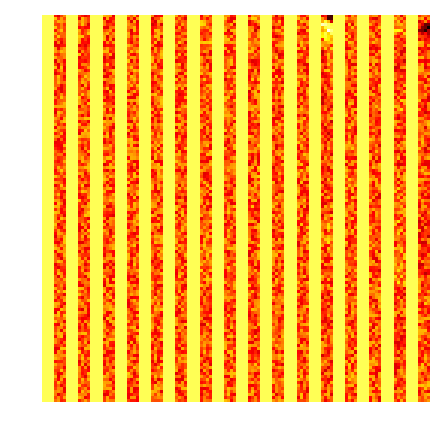

In [29]:
plt.figure(figsize=(5, 5), dpi=500)
W = lasagne.layers.get_all_params(nn)[0].get_value()
W[::2, :, :] = 0.2
W = np.hstack(W)
pylab.imshow(W, cmap='hot', interpolation="nearest")
pylab.axis('off')
pylab.show()

# Maps of tracks by SVD and tSNE

Хорошая идея посмотреть, как полученое представление отображается с сохранением относительных расстояний на плоскость. Используйте tSNE или PCA.

Help: https://lts2.epfl.ch/blog/perekres/category/visualizing-hidden-structures-in-datasets-using-deep-learning/

In [30]:
from sklearn.manifold import TSNE

In [31]:
represent = lasagne.layers.get_output(nn.input_layer)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [32]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = map(f, X_train) + map(f, X_valid)
track_vectors = np.concatenate(track_vectors, axis=0)

track_labels = np.array(list(y_train) + list(y_valid))

получите 2d вектора

In [33]:
%%time

tsne = TSNE()
X_tsne = tsne.fit_transform(track_vectors)
print X_tsne.shape

(12000, 2)
CPU times: user 2min 45s, sys: 14.3 s, total: 2min 59s
Wall time: 2min 58s


нарисуйте получившиеся точки

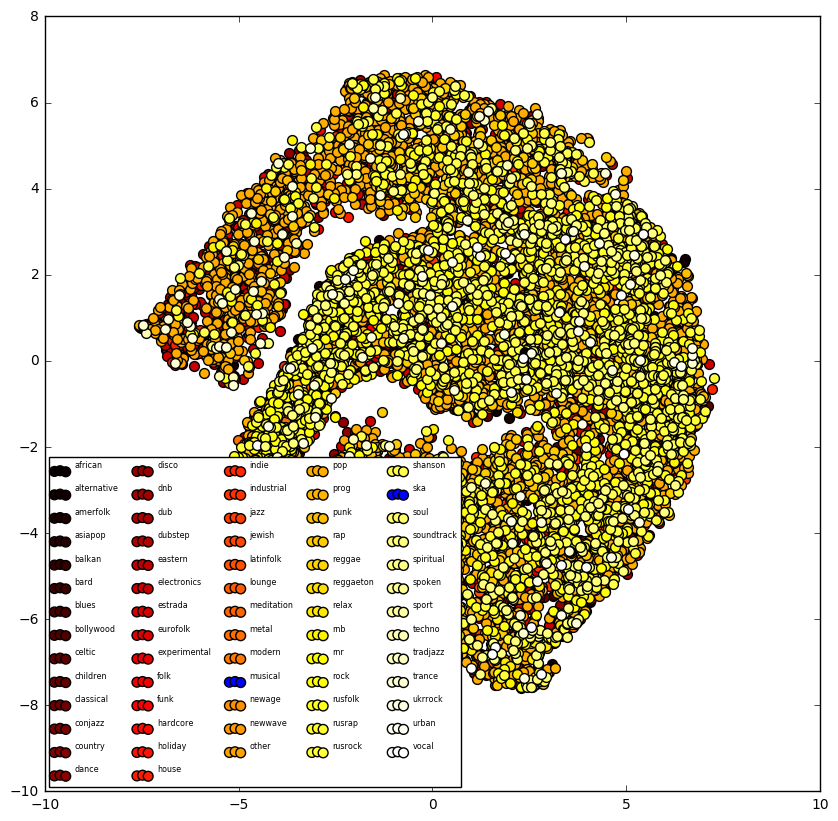

In [34]:
plt.figure(figsize=(10,10), dpi=500)
id2gener = { genre_id: encoder.inverse_transform([genre_id])[0] for genre_id in xrange(num_classes) }
colors = cm.hot(np.linspace(0, 1, len(id2gener)))

for idx, gener in id2gener.items():
    idx_ = np.where(track_labels == idx)
    pylab.scatter(X_tsne[idx_, 0], X_tsne[idx_, 1], c=colors[idx], cmap=cm.hot, label=gener,s=50)

pylab.legend(loc='lower left', ncol=5, fontsize='xx-small')